In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

[데이터셋]

http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [16]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

cloud_path = '/content/drive/MyDrive/Colab Notebooks/'

df = pd.read_csv(cloud_path + "kddcup.data.corrected", sep=",", names=columns, index_col=None)

In [17]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [18]:
df.shape

(4898431, 42)

In [19]:
df["service"].value_counts()

ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
harvest            2
aol                2
http_8001          2
http_2784          1
Name: service, Length: 70, dtype: int64

HTTP공격인 것만 따로 뺀다.

In [20]:
df = df[df["service"] == 'http']
df = df.drop("service", axis = 1)
columns.remove("service")

In [21]:
df.shape

(623091, 41)

In [22]:
df["label"].value_counts()

normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: label, dtype: int64

# 하단 코드를 잘 기억해두자  
  
레이블 인코더를 활용해서 카테고리컬 데이터를 바로 클래스변수로 매핑해준다.

In [23]:
for col in df.columns:
  if df[col].dtype == "object":
    encoded = LabelEncoder()
    encoded.fit(df[col])
    df[col] = encoded.transform(df[col])

In [24]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,9,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4
1,0,0,9,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4
2,0,0,9,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,4
3,0,0,9,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,4
4,0,0,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,4


In [26]:
for f in range(0, 3): #3번 셔플한다는 뜻인듯?
  df = df.iloc[np.random.permutation(len(df))]

df2 = df.iloc[np.random.permutation(len(df))] #그걸 또 셔플 
labels = df2["label"] 
df_validate = df[500000:]

x_train, x_test, y_train, y_test = train_test_split(df2, labels, test_size = 0.2, random_state = 42)

x_val, y_val = df_validate, df_validate["label"]

In [27]:
print("Shapes : \nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("x_val:%s\ny_val:%s\n" % (x_val.shape, y_val.shape))

Shapes : 
x_train:(498472, 41)
y_train:(498472,)

x_test:(124619, 41)
y_test:(124619,)

x_val:(123091, 41)
y_val:(123091,)



In [31]:
isolation_forest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1, random_state=42) 

#n_estimators : number of trees in the forest 
#max_samples : maximum number of data points that the tree should build on
#contamination : estimate of the percentage of the entire data set that should be considered an anomaly/outlier
#random_state : initialize the random number generator with to use during the training process

In [32]:
isolation_forest.fit(x_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.1, max_samples=256, random_state=42)

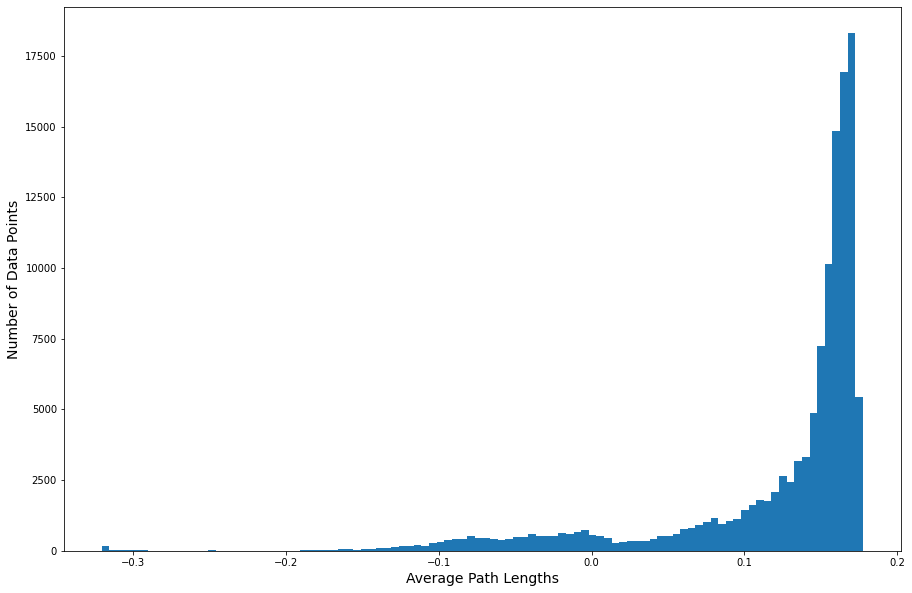

In [34]:
anomaly_scores = isolation_forest.decision_function(x_val)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores, bins = 100)
plt.xlabel("Average Path Lengths", fontsize=14)
plt.ylabel("Number of Data Points", fontsize=14)
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

def get_score(score):
  anomalies = anomaly_scores > score
  matches = y_val == list(encoded.classes_).index("normal.")
  auc = roc_auc_score(anomalies, matches)
  print("AUC: {:.2%}".format(auc))

In [46]:
score = -0.19 #AUC가 -0.2가 훨 높은데?? 책이랑 내용이 좀 다르다???
get_score(score) 

AUC: 97.47%


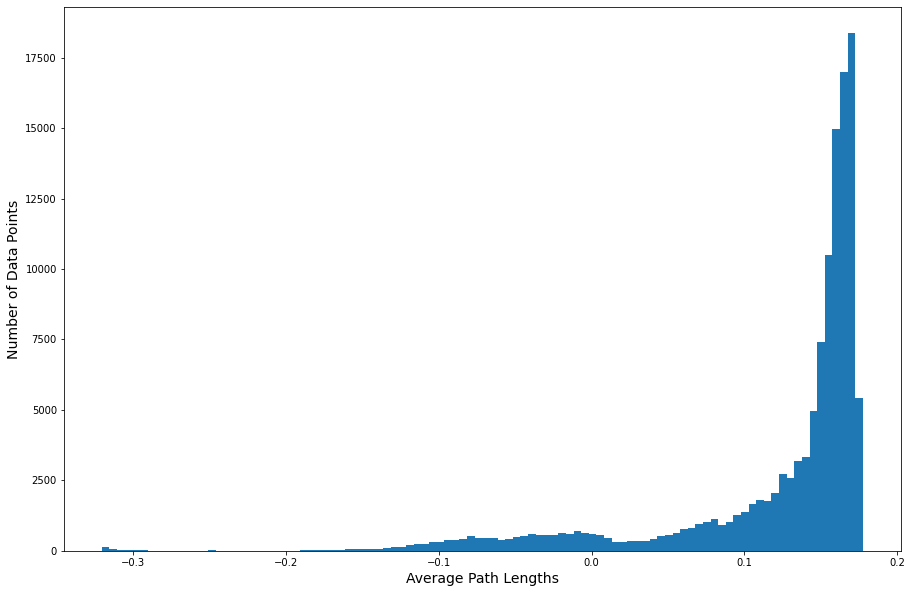

In [48]:
anomaly_scores_test = isolation_forest.decision_function(x_test)
plt.figure(figsize = (15, 10))
plt.hist(anomaly_scores_test, bins = 100)
plt.xlabel("Average Path Lengths", fontsize = 14)
plt.ylabel("Number of Data Points", fontsize = 14)
plt.show()

In [50]:
anomalies_test = anomaly_scores_test > -0.19 
matches = y_test == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies_test, matches)
print("AUC: {:.2%}".format(auc)) #테스트데이터가 더 높네?

AUC: 98.25%
